In [10]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [11]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [12]:
q4_dp = {'1-URGENT': [1.9094966190370435,
  1.4390167527426396,
  0.9905998292811071,
  0.6914595858610769,
  0.46419855560261797,
  0.31079773045000797,
  0.17593472263054316,
  0.04416950355088001,
  0.04375585811854141,
  0.042652271600614695],
 '2-HIGH': [2.0380113214257403,
  1.4006948453598298,
  1.0362043387791677,
  0.6815240241527991,
  0.46012590791650193,
  0.31987457214214776,
  0.16049147051813964,
  0.04476538026303727,
  0.04502451991323763,
  0.04347198844732975],
 '3-MEDIUM': [2.015067079989976,
  1.3656586075759645,
  0.985136793056168,
  0.6680317514185643,
  0.44201784625012314,
  0.29375011856122263,
  0.16316300840274026,
  0.0427369536474568,
  0.041347286714669786,
  0.040849264576639496],
 '4-NOT SPECIFIED': [2.0639185449041406,
  1.384206214467273,
  1.064612070607331,
  0.6884686281536756,
  0.4840810775535314,
  0.3230233935064605,
  0.1731452507848902,
  0.04499361879423069,
  0.041972392832094134,
  0.04308354963735532],
 '5-LOW': [1.7801016596146355,
  1.2906843551266087,
  0.894379340448067,
  0.6804902222560051,
  0.43711682319118156,
  0.28034385440181425,
  0.16442136400801968,
  0.039964944871300236,
  0.04219007226291092,
  0.0374625929465158]}

In [13]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range

    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
                print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        markersize=10, mew=1.5)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])

        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=14)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative Error (%)', fontsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=16)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('figs/q1_results.png')

In [14]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', markersize=10, mew=1.5)

    ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
    ax.set_ylabel(f'Relative Error (%)', fontsize=14)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=16)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figs/q14_results.png')

In [15]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', markersize=10, mew=1.5
                )
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', markersize=10, mew=1.5)

        ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
        ax.set_ylabel(f'Relative Error (%)', fontsize=14)
        ax.set_title(f'Approximating Order Count Difference Percentage ({labels[i]})', fontsize=16)
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figs/q4_results.png')

In [16]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', markersize=10, mew=1.5,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

        ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
        ax.set_ylabel(f'Relative Error (%)', fontsize=14)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('figs/q12_results.png')

In [17]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

Q1
A F [5.0145618942103996, 3.7938526953303353, 2.726870815623806, 1.9869694056873333, 1.4590910083914437, 1.1282162703117038, 0.8753103410298668, 0.8058333992567255, 0.7080440779547816, 0.7222682125188317]
A O []
N F [12.88082756267124, 9.673206428940606, 6.998636559881052, 4.963548416099709, 3.7725459081359793, 2.7952944837367633, 2.390458915788992, 1.9906386055149117, 1.7989859771967904, 1.814024807062539]
N O [5.368336580099081, 3.806231262616964, 2.786924844336354, 2.0749372978827783, 1.4942174509489874, 1.1732195683869158, 0.9442524136786974, 0.8533251008052932, 0.788231393590314, 0.7489889543292306]
R F [5.316788546453921, 3.8001178240728004, 2.65318073734511, 2.0465679855335237, 1.54743929789288, 1.1732752088799052, 0.9677351307657514, 0.7824559218835041, 0.7726895256893533, 0.7016553357220778]
R O []
A F [1.047334332027573, 0.757619395168856, 0.5477115168873581, 0.419321047310878, 0.2884305149330653, 0.22012833789460984, 0.18382520438257824, 0.15384487878950917, 0.148069305911

Q12
priority
[25.57558352064703, 18.68899102064156, 12.749679677796184, 9.800410669014719, 7.055149405063928, 5.478734798377107, 4.623463088297873, 4.0628955683776375, 3.6661024901184738, 3.560420143067243]
priority
[26.44016750431175, 18.86764225491618, 13.563565925957821, 9.679025521564565, 7.293561869448171, 5.654901974834059, 4.522378885881758, 4.113356481172492, 3.505732228895472, 3.4960551054441598]
priority
[22.81848555949615, 16.276691280213118, 11.311882883857809, 8.193065809395705, 6.131634503586392, 5.149746470699655, 3.8271382401818785, 3.4064387354634946, 3.141739297667674, 2.982399699938734]
priority
[20.221228378411094, 14.344071204336032, 10.432183397752313, 7.3756977012183365, 5.893394168651698, 4.283120684281447, 3.4119186794534277, 2.9823505041282132, 2.8732423307108776, 2.604223802163325]
Q14!
[20.261753967304948, 14.679983822832225, 10.69826560906667, 7.739777975749294, 5.638663517080318, 4.382684922873535, 3.3901144583180174, 3.1014604656111175, 2.8570435621437835

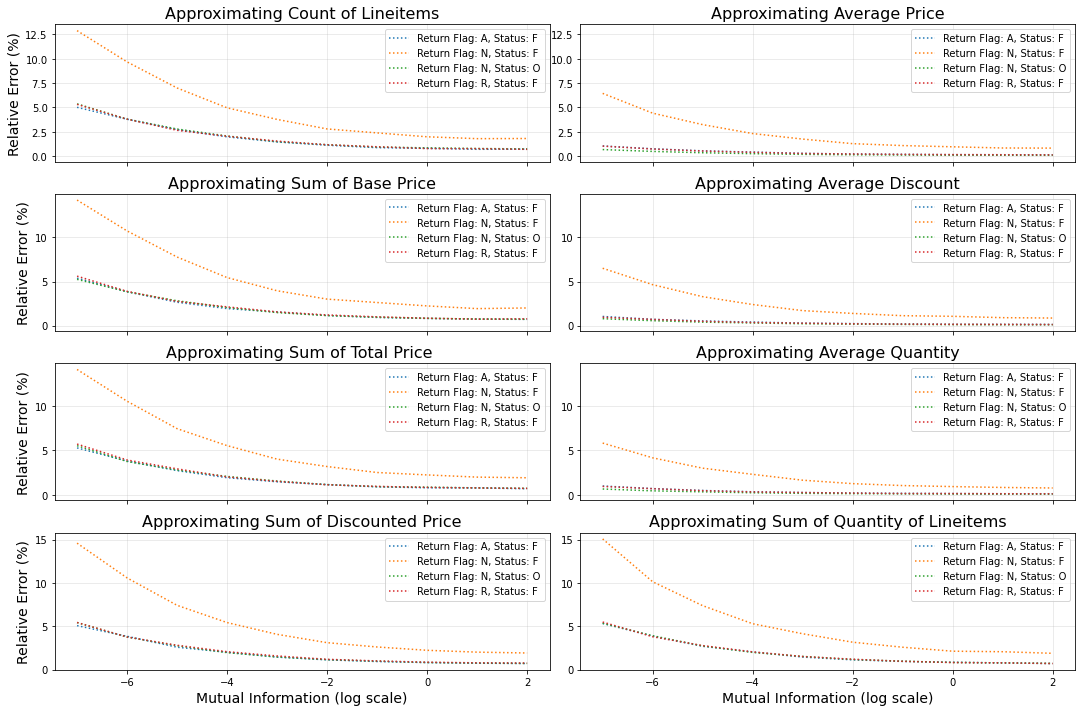

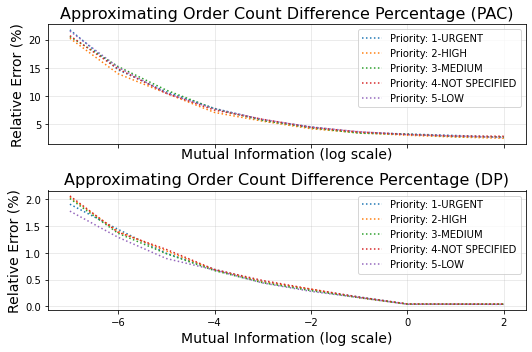

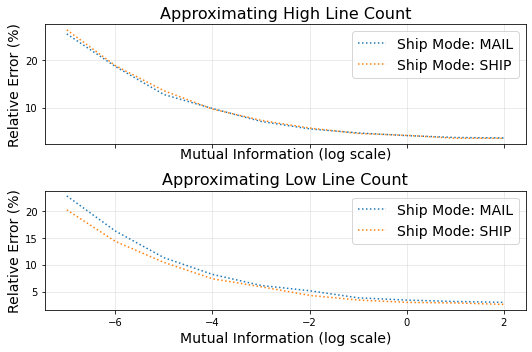

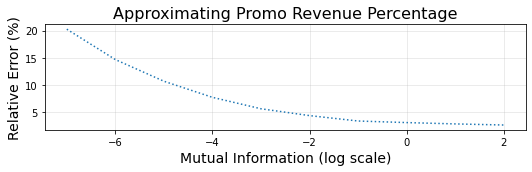

In [18]:
for query_ind in [1, 4, 12, 14]:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer--{mi}--step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    new = np.average(
                        [100*abs(
                            const*merged_df[noised][ind][tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(merged_df[noised][ind]))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
    graph_query(full_df, query_ind)

In [23]:
tmp1 = pl.read_json('outputs/ap-duckdb-q4-customer-step1/random_binary.json')

In [31]:
for i in range(len(tmp1)):
    print(sum(tmp1[i]['random_binary'].to_list()[0]))

7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
7500
7501
